# Zillow Regression Project

## Project Overview

Ability to predict the values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" (in terms of real estate demand) of May-August, 2017.

## Project Goal

The purpose of this notebook is create a regression model that predicts home values in a tri-county area of California (Los Angeles County, Orange County, and Ventrua County)

## Executive Summay

Square footage, number of bathrooms, number of bedrooms, and property age were features used to make a model that predicts home values in California

We used 3 features to build our model Bathroom count, Bedroom Count, and Square Feet of property

## Hypothesis
1.) The larger the square footage, the higher the property value

2.) The more bedrooms a house has, the higher its property value will be

3.) The more bathrooms a house has, the higher its property value will be



In [47]:
#import stuff we will need
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from prep import remove_outlier,clean_zillow, train_validate_test, get_object_cols, get_numeric_X_cols, min_max_scale,clean_zillow_taxes,remove_outlier_tax
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from explore import plot_variable_pairs, plot_pairplot, correlation_exploration, get_zillow_heatmap

#import functions from my .py files
from acquire import new_zillow, get_zillow_data

# Acquire Data

In [2]:
#acquire our Zillow data from CodeUp server by parcel id specifically those that are single unit property values.
df = new_zillow()

In [3]:
# over 38k rows and 62 columns
df

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,None,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,None,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,None,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,None,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,None,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,None,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,None,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38617,14453399,356752,NaN,NaN,NaN,3.0,5.0,None,NaN,3.0,...,852813.0,2016.0,496831.0,11662.88,None,NaN,6.059032e+13,72840,0.062928,2017-08-31
38618,12019061,2108804,1.0,NaN,NaN,2.0,1.0,None,9.0,2.0,...,492395.0,2016.0,366200.0,6023.37,None,NaN,6.037701e+13,72841,0.000231,2017-08-31
38619,11570288,108621,1.0,NaN,NaN,2.0,2.0,None,7.0,2.0,...,600608.0,2016.0,446625.0,7255.87,None,NaN,6.037264e+13,72842,-0.003178,2017-08-31
38620,11128688,2001476,1.0,NaN,NaN,3.0,5.0,None,7.0,3.0,...,1120000.0,2016.0,728000.0,13663.03,None,NaN,6.037108e+13,72843,0.024946,2017-08-31


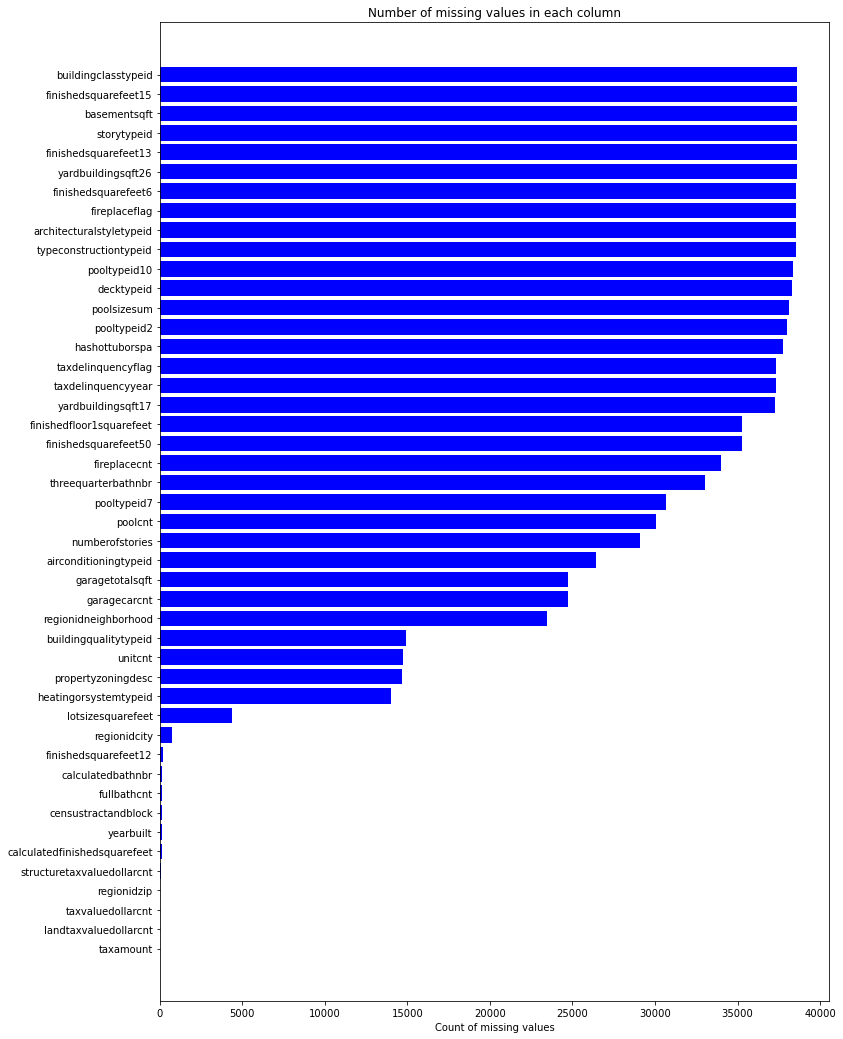

In [4]:
# visualize missing values

missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

### Takeaways:

Lots of columns and null values

Look for missing values by percentages

We won't need most of these columns

# Prepare Data

In [5]:
#clean_zillow will only select relevant columns, rename columns, drop duplicates, and drop/fill in nulls
#we now are down to 38,475 rows and 6 columns.
df = clean_zillow(df)
df.shape

(38475, 6)

In [6]:
#assuring there are no null values
df.isna().sum()

sqft         0
baths        0
beds         0
tax_value    0
fips         0
age          0
dtype: int64

In [7]:
# function removes outliers greater then 3 standard deviations from the mean

df = remove_outlier(df)

In [8]:
#let's split our data using my train_validate_test function, and check our train, validate, and test shapes. Our target is tax_value.
target = 'tax_value'
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, target)
train.shape, validate.shape, test.shape

((21238, 6), (9103, 6), (7586, 6))

In [9]:
#let's scale our data using the min_max_scale function. Not scaling the target. 
obj_cols = get_object_cols(df)
num_cols = get_numeric_X_cols(X_train, obj_cols)
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, num_cols)

Takeaways from Prepare

- There were a small percentage of null values that we removed
- There were a small amount of outliers that we removed by deleting any data outside 3 standard deviations


# Explore 

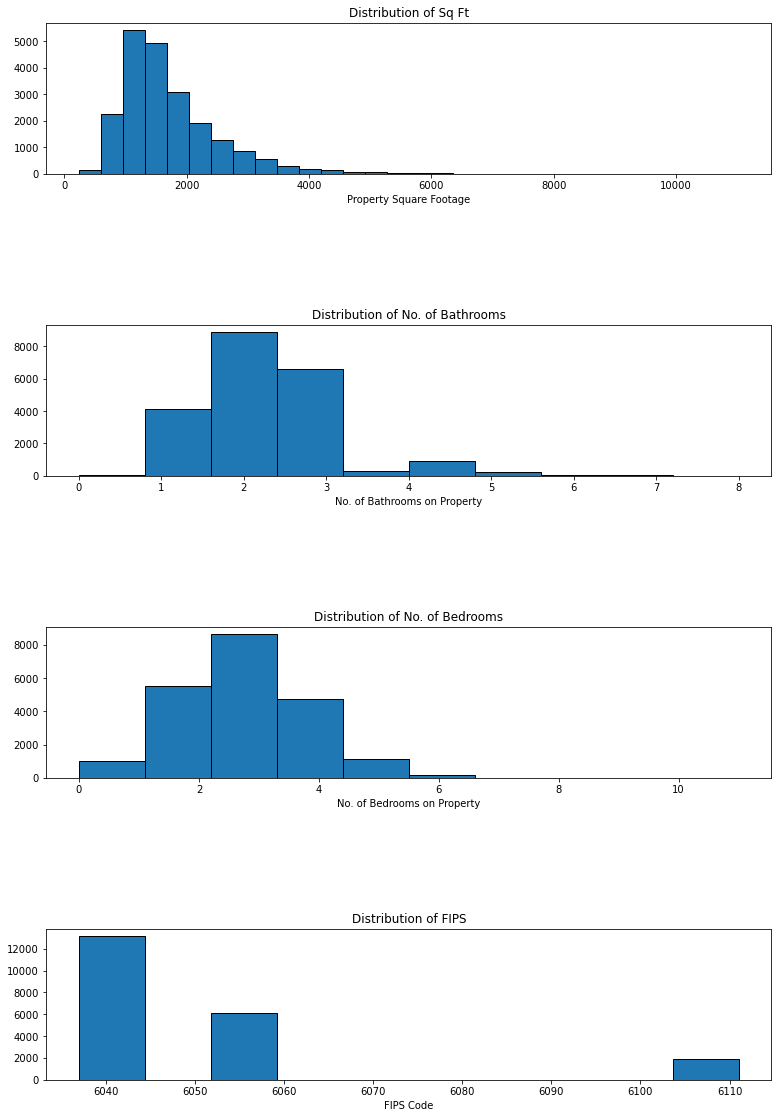

In [10]:
#checking distributions of our selected features/univariate exploration
plt.figure(figsize=(13,25))
plt.subplot(5,1,1, xlabel = 'Property Square Footage', title='Distribution of Sq Ft')
plt.hist(data=train, x='sqft', bins = 30,ec='black')

plt.subplot(5,1,2, xlabel = 'No. of Bathrooms on Property',title='Distribution of No. of Bathrooms')
plt.hist(data=train, x='baths', ec='black')

plt.subplot(5,1,3, xlabel = 'No. of Bedrooms on Property', title='Distribution of No. of Bedrooms')
plt.hist(data=train, x='beds',ec='black')

plt.subplot(5,1,4, xlabel = 'FIPS Code',title='Distribution of FIPS')
plt.hist(data=train, x='fips',ec='black')

plt.subplots_adjust(hspace=1)
plt.show()

In [11]:
#our columns of the dataframe
cols = ['sqft', 'baths','beds', 'fips','tax_value']

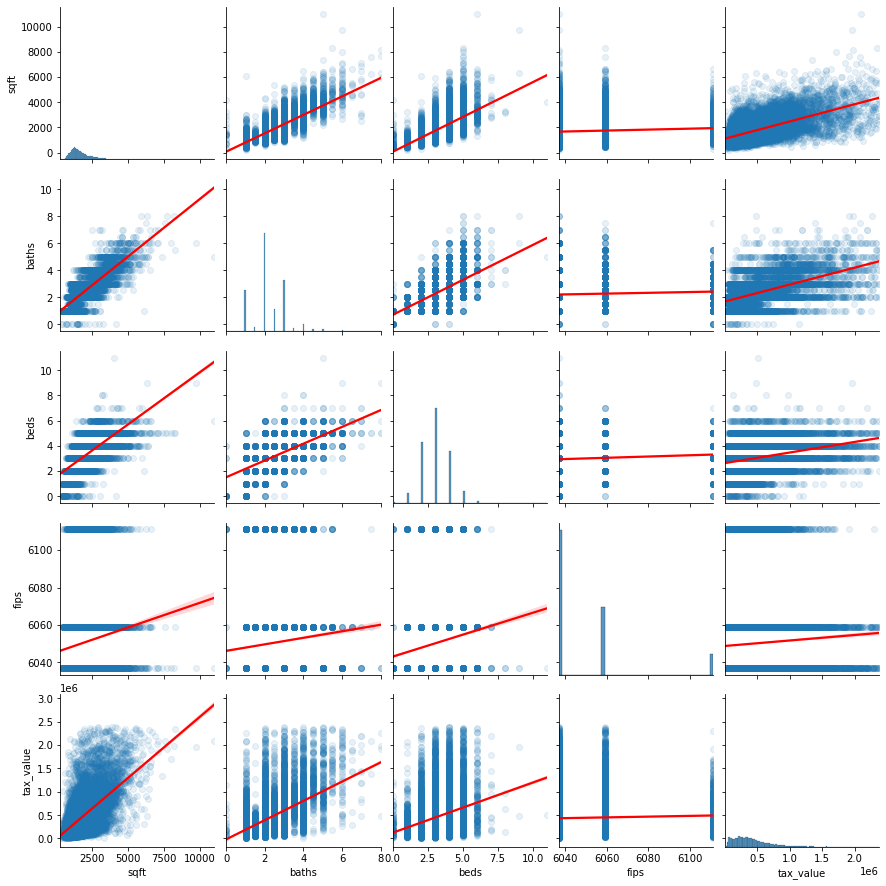

In [12]:
#pairplots 
plot_variable_pairs(train, cols)

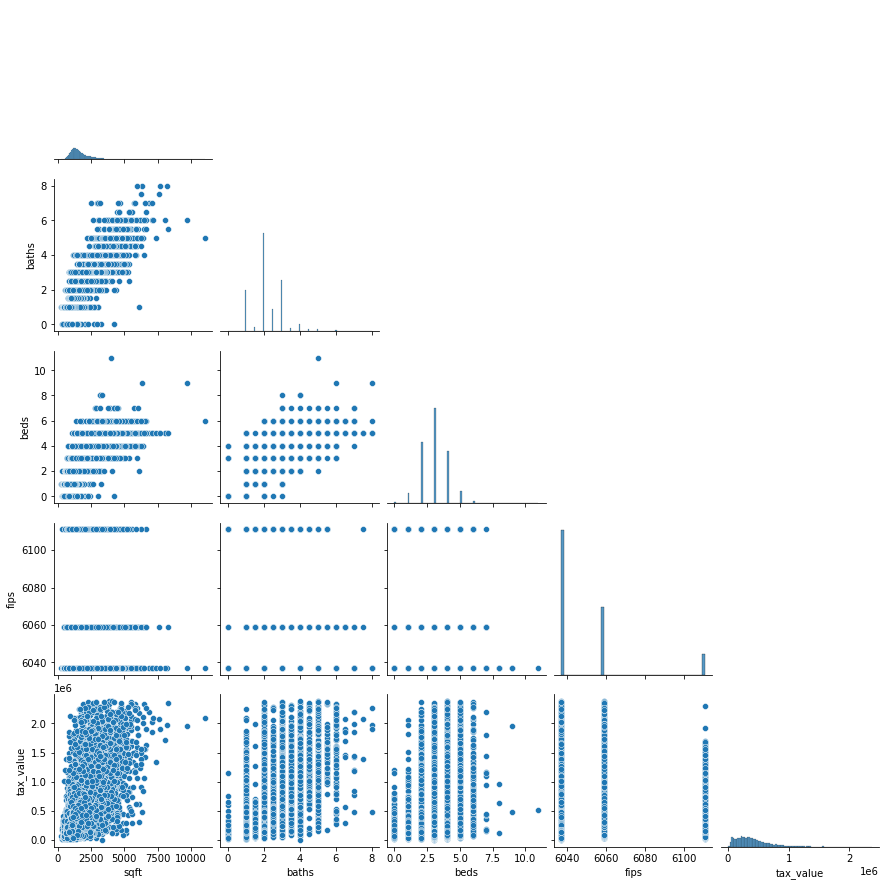

In [13]:
#scatter plots and histograms
plot_pairplot(train, cols, hue=None)

<AxesSubplot:title={'center':'Feautures Correlating with Value'}>

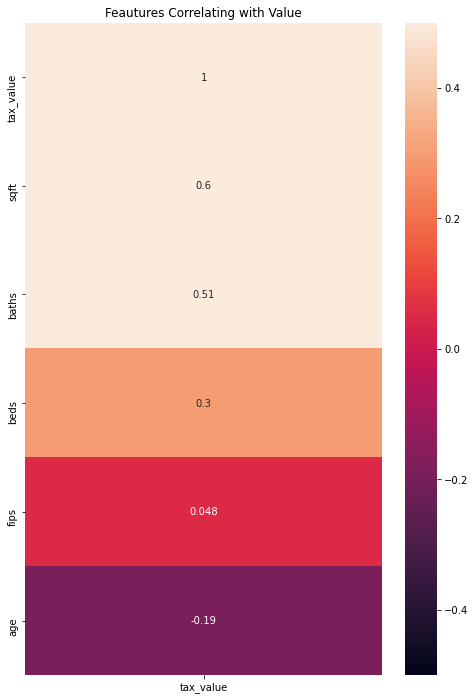

In [14]:
#heatmap with correlation of feature to tax_value
get_zillow_heatmap(train)

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.3


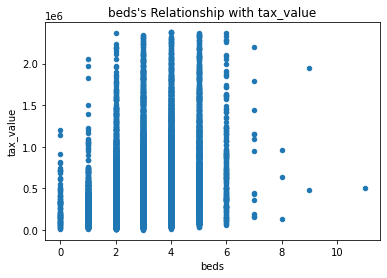

In [15]:
correlation_exploration(train, 'beds', 'tax_value')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.51


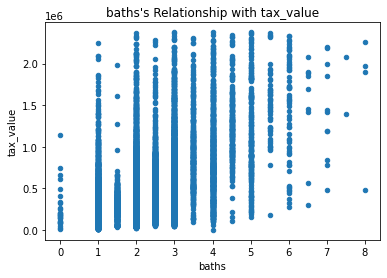

In [16]:
correlation_exploration(train, 'baths', 'tax_value')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.6


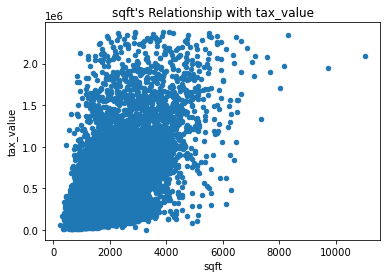

In [17]:
#sqft and tax_value
correlation_exploration(train, 'sqft', 'tax_value')

The p-value is: 1.5961658280325072e-12. There is 0.0% chance that we see these results by chance.
r = 0.05


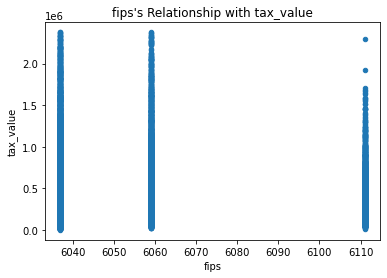

In [18]:
#FIPS and tax_value
correlation_exploration(train, 'fips', 'tax_value')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.59


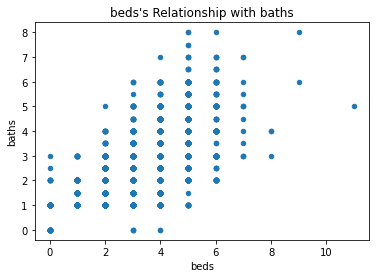

In [19]:
#Correlation between beds and baths, seems that they have a positive correlation with each other.
correlation_exploration(train, 'beds', 'baths')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.68


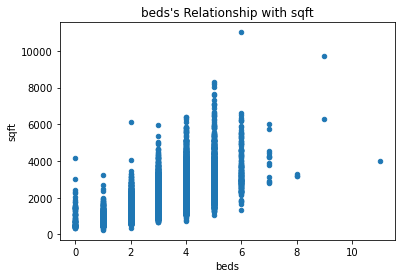

In [20]:
#Correlation between beds and sqft, seems that they have a positive correlation with each other.
correlation_exploration(train, 'beds', 'sqft')

### Hypothesis 1

𝐻0 : Houses > 1600 square feet are independent of their tax value price

𝐻𝑎 : Houses <= 1600 square feet have a significant outcome on their tax value price

In [21]:
null_hypothesis = "Houses > 1600 square feet are independent of their tax value price"
alternative_hypothesis = "Houses <= 1600 square feet have a significant outcome on their tax value price"
a = 0.05 #a for alpha 

big_house = train[train.sqft>1600]
small_house = train[train.baths<=1600]
t, p = stats.ttest_ind(big_house.tax_value, small_house.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Houses > 1600 square feet are independent of their tax value price
There is evidence to suggest: Houses <= 1600 square feet have a significant outcome on their tax value price


### Hypothesis 2

𝐻0 : Houses with 2 bedrooms or more and houses with less than 2 bedrooms are independent to value of home

𝐻𝑎 : Houses with 2 bedrooms or more and houses with less than 2 bedrooms are related to value of home

In [22]:
a = 0.05 #a for alpha 

two_or_more_beds = train[train.beds>=2]
less_than_two_beds = train[train.beds<2]
t, p = stats.ttest_ind(two_or_more_beds.tax_value, less_than_two_beds.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Houses > 1600 square feet are independent of their tax value price
There is evidence to suggest: Houses <= 1600 square feet have a significant outcome on their tax value price


### Hypothesis 3

In [23]:
null_hypothesis = "Houses with 2 bathrooms or more and houses with less than 2 bathrooms are independent to value of home"
alternative_hypothesis = "Houses with 2 bathrooms or more and houses with less than 2 bathrooms are related to value of home"
a = 0.05 #a for alpha 

two_or_more_baths = train[train.baths>=2]
less_than_two_baths = train[train.baths<2]
t, p = stats.ttest_ind(two_or_more_baths.tax_value, less_than_two_baths.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Houses with 2 bathrooms or more and houses with less than 2 bathrooms are independent to value of home
There is evidence to suggest: Houses with 2 bathrooms or more and houses with less than 2 bathrooms are related to value of home



#### Statistical Testing Takeaways¶
The features we hypothesized have strong correlations with our target variable and proven to be significant from our correlation tests

By running t and p tests on our 3 main features as well after creating categories. We have determined that the 3 main features (sqft, bedrooms, and bathrooms) have a high impact on our target variable = tax_value

# Modeling 

In [24]:
# FIPS and age will not be used in the modeling. Only the top 3.

In [25]:
cols = list(X_train.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 5)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['sqft', 'baths', 'beds', 'fips', 'age'], dtype='object')


In [26]:
selected_features = ['sqft', 'baths', 'beds']

## Establishing Mean and Median Baseline

In [27]:
#turning my y_train and y_validate to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

#tax_value mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

#tax_value_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

#RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print('BASELINE')
print('--------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
print('--------------------')

#RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

## R squared score for baseline
print('-----------------------------')
r2_baseline = r2_score(y_validate.tax_value, y_validate.tax_value_pred_mean)
print(f'The R squared score for the baseline is {r2_baseline}')



BASELINE
--------------------
RMSE using Mean
Train/In-Sample:  357185.61 
Validate/Out-of-Sample:  359454.06
--------------------
RMSE using Median
Train/In-Sample:  367038.13 
Validate/Out-of-Sample:  369101.89
-----------------------------
The R squared score for the baseline is -3.072081049992903e-06


#### To beat our baseline, we need RMSEs lower than 359,454 and an r^2 better than -3 

In [28]:
#Our first model: LinearRegression
#create model object
lm = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm.fit(X_train_scaled[selected_features],y_train.tax_value)

#predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

#predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression:\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lm = r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm)
print(f'The r^2 value for linear regression is {round(r2_score_lm,3)}')

RMSE for OLS using LinearRegression:
Training/In-Sample:  280905.50455498934 
Validation/Out-of-Sample:  279770.98737786006
The r^2 value for linear regression is 0.394


In [29]:
#LassoLars 
#create model object
lars = LassoLars(alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
lars.fit(X_train_scaled[selected_features],y_train.tax_value)

#predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

#predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for OLS using Lasso+Lars\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lars = r2_score(y_validate.tax_value, y_validate.tax_value_pred_lars)
print(f'The r^2 value for LassoLars regression is {round(r2_score_lars,3)}')

RMSE for OLS using Lasso+Lars
Training/In-Sample:  280905.75218896917 
Validation/Out-of-Sample:  279776.13612741337
The r^2 value for LassoLars regression is 0.394


In [30]:
#TweedieRegressor, I found using 0 power and 0 for alpha yielded the best results...
#create model object
glm = TweedieRegressor(power =0, alpha=0.00)

#fit the model to our training data, specify column since it is a dataframe
glm.fit(X_train_scaled[selected_features],y_train.tax_value)

#predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

#predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for OLS using TweedieRegressor\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_glm = r2_score(y_validate.tax_value, y_validate.tax_value_pred_glm)
print(f'The r^2 value for TweedieRegressor is {round(r2_score_glm,3)}')

RMSE for OLS using TweedieRegressor
Training/In-Sample:  280905.50455498934 
Validation/Out-of-Sample:  279770.98738065775
The r^2 value for TweedieRegressor is 0.394


In [31]:
#making polynomial features to get a new set of features, I found that degree=3 yielded the best results.
pf = PolynomialFeatures(degree=3)

#fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled[selected_features])

#transform X_validate_scaled, and X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled[selected_features])
X_test_degree3 = pf.transform(X_test_scaled[selected_features])

#okay let's do linear regression again with our new degree
lm3 = LinearRegression(normalize=True)

#fit the model using scaled X_train, once again specify y_train column
lm3.fit(X_train_degree3, y_train.tax_value)

#predict train
y_train['tax_value_pred_lm3'] = lm3.predict(X_train_degree3)

#evaluate rmse for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm3)**(1/2)

#predict validate
y_validate['tax_value_pred_lm3'] = lm3.predict(X_validate_degree3)

#evaluate rmse for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lm3 = round(r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm3),2)
print(f'The r^2 value for Polynomial is {round(r2_score_lm3,3)}')

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  278845.48485599464 
Validation/Out-of-Sample:  277370.6837261469
The r^2 value for Polynomial is 0.4


Polynomial Model (degrees=3) performed the best.

It has the lowest RMSE, lowest variance between training/validate, and highest r^2. 

We will use this for our test

Text(0.5, 1.0, 'Residuals')

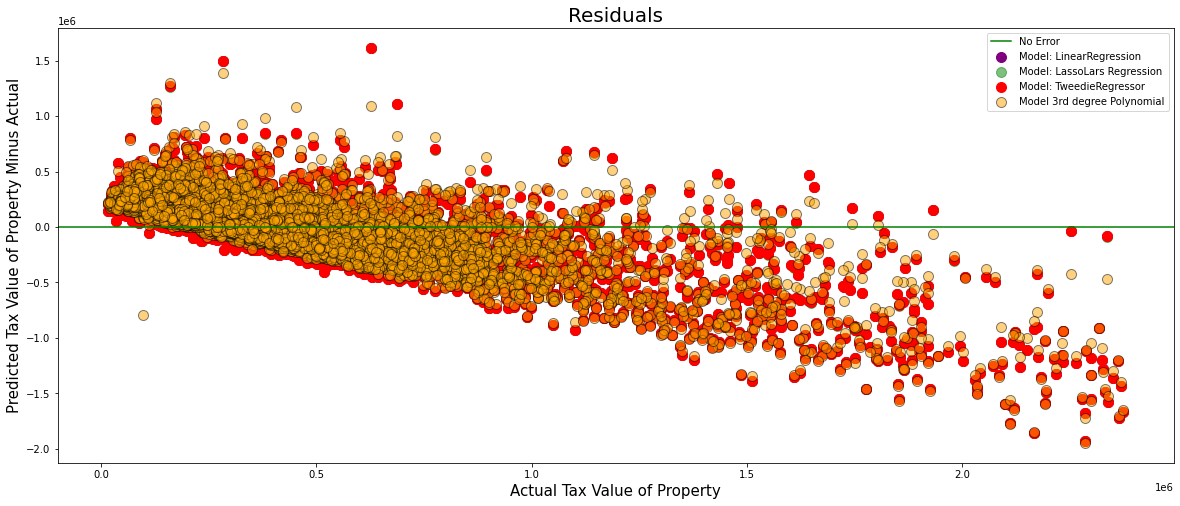

In [32]:
plt.figure(figsize=(20,8))
plt.axhline(label="No Error", color="green")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm-y_validate.tax_value, 
            alpha=1, color="purple", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lars-y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model: LassoLars Regression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm-y_validate.tax_value, 
            alpha=1, color="red", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm3-y_validate.tax_value, 
            alpha=.5, color="orange", s=100, edgecolors='black', label="Model 3rd degree Polynomial")
plt.legend()

plt.xlabel("Actual Tax Value of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Tax Value of Property Minus Actual", fontdict={'fontsize':15})
plt.title("Residuals", fontdict={'fontsize': 20})

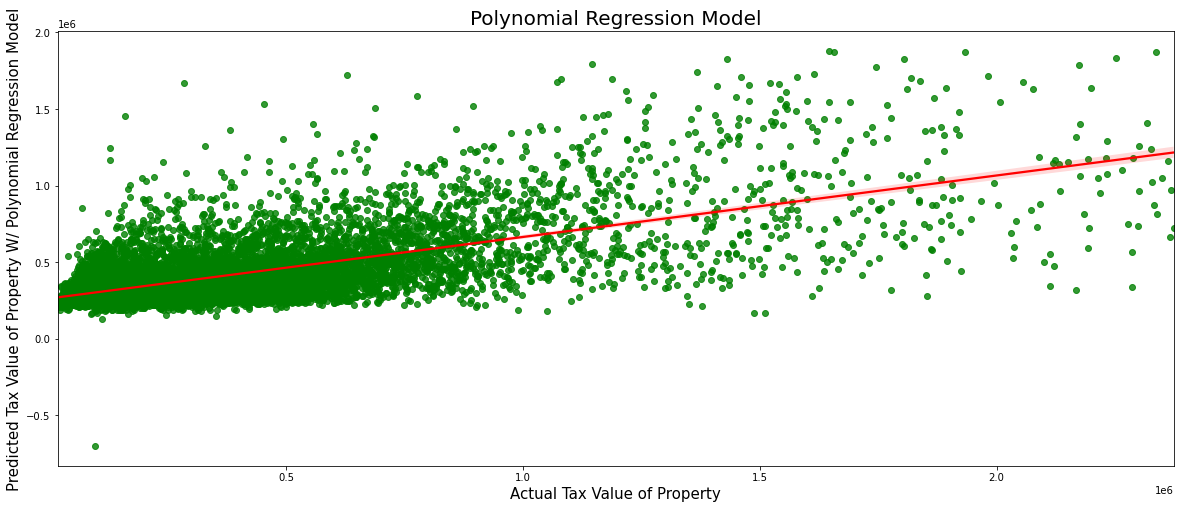

In [53]:
#looks like 3rd degree polynomial did the best, let's visualize that
plt.figure(figsize=(20,8))

sns.regplot(data=y_test, x=y_validate.tax_value, y=y_validate.tax_value_pred_lm3, 
            scatter_kws={'color':'green'}, line_kws={'color':'red'})
plt.xlabel("Actual Tax Value of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Tax Value of Property W/ Polynomial Regression Model", fontdict={'fontsize':15})
plt.title("Polynomial Regression Model", fontdict={'fontsize': 20})

plt.show()

## Test 

In [34]:
# predicting on our test model
y_test['tax_value_pred_lm3'] = lm3.predict(X_test_degree3)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm3)**(1/2)
print('             ')
print('             Our Test Model')
print('----------------------------------')
print('----------------------------------')
print("RMSE for OLS Model using Polynomial (3 degrees)\nOut-of-Sample Performance: ", rmse_test)
r2_test_score_lm3 = r2_score(y_test.tax_value, y_test.tax_value_pred_lm3)
print(f'Polynomial Regression (3 degrees) has an R^2 value of {round(r2_test_score_lm3,3)}')

             
             Our Test Model
----------------------------------
----------------------------------
RMSE for OLS Model using Polynomial (3 degrees)
Out-of-Sample Performance:  276414.5975274719
Polynomial Regression (3 degrees) has an R^2 value of 0.384


Our test model (Polynomial regression, 3 degrees) performs better than the baseline. 

It has a lower RMSE, lower variance between test/validate, and has a higher r^2 value

Takeaways:

Square footage was the best feature for predicting home value, followed up by bathrooms and bedrooms.



# Tax Rates For Each County

In [35]:
#Now we need to calculate tax rate for each county, an approximate actually.
df = get_zillow_data()
df

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,NaN,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,NaN,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,NaN,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38617,14453399,356752,NaN,NaN,NaN,3.0,5.0,NaN,NaN,3.0,...,852813.0,2016.0,496831.0,11662.88,NaN,NaN,6.059032e+13,72840,0.062928,2017-08-31
38618,12019061,2108804,1.0,NaN,NaN,2.0,1.0,NaN,9.0,2.0,...,492395.0,2016.0,366200.0,6023.37,NaN,NaN,6.037701e+13,72841,0.000231,2017-08-31
38619,11570288,108621,1.0,NaN,NaN,2.0,2.0,NaN,7.0,2.0,...,600608.0,2016.0,446625.0,7255.87,NaN,NaN,6.037264e+13,72842,-0.003178,2017-08-31
38620,11128688,2001476,1.0,NaN,NaN,3.0,5.0,NaN,7.0,3.0,...,1120000.0,2016.0,728000.0,13663.03,NaN,NaN,6.037108e+13,72843,0.024946,2017-08-31


In [36]:
#Made a new clean function for taxes
# tax_rate = tax_amount / tax_value 
cal_tax = clean_zillow_taxes(df)
cal_tax

,sqft,baths,beds,tax_value,fips,tax_amount,age,tax_rate
parcel_id,,,,,,,,
14634203,1125.0,2.0,3.0,289445.0,6059.0,3490.16,43.0,0.012058
11721753,1316.0,2.0,3.0,205123.0,6037.0,2627.48,94.0,0.012809
11289917,1458.0,2.0,3.0,136104.0,6037.0,2319.90,47.0,0.017045
11637029,1766.0,2.0,3.0,810694.0,6037.0,9407.01,37.0,0.011604
11705026,1421.0,1.0,2.0,35606.0,6037.0,543.69,106.0,0.015270
...,...,...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,6059.0,11662.88,15.0,0.013676
12019061,769.0,2.0,1.0,492395.0,6037.0,6023.37,53.0,0.012233
11570288,1212.0,2.0,2.0,600608.0,6037.0,7255.87,48.0,0.012081


In [37]:
#Now we're going to remove outliers, just in case anything is a bit extreme. 
cal_tax = remove_outlier_tax(cal_tax)

In [38]:
cal_tax

,sqft,baths,beds,tax_value,fips,tax_amount,age,tax_rate
parcel_id,,,,,,,,
14634203,1125.0,2.0,3.0,289445.0,6059.0,3490.16,43.0,0.012058
11721753,1316.0,2.0,3.0,205123.0,6037.0,2627.48,94.0,0.012809
11289917,1458.0,2.0,3.0,136104.0,6037.0,2319.90,47.0,0.017045
11637029,1766.0,2.0,3.0,810694.0,6037.0,9407.01,37.0,0.011604
11705026,1421.0,1.0,2.0,35606.0,6037.0,543.69,106.0,0.015270
...,...,...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,6059.0,11662.88,15.0,0.013676
12019061,769.0,2.0,1.0,492395.0,6037.0,6023.37,53.0,0.012233
11570288,1212.0,2.0,2.0,600608.0,6037.0,7255.87,48.0,0.012081


In [39]:
#going to create a new column called county, and it's going to give us the county name based off the FIPS number. 
#fips numbers were googled
cal_tax['county'] = cal_tax['fips'].map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})
cal_tax

,sqft,baths,beds,tax_value,fips,tax_amount,age,tax_rate,county
parcel_id,,,,,,,,,
14634203,1125.0,2.0,3.0,289445.0,6059.0,3490.16,43.0,0.012058,Orange
11721753,1316.0,2.0,3.0,205123.0,6037.0,2627.48,94.0,0.012809,Los Angeles
11289917,1458.0,2.0,3.0,136104.0,6037.0,2319.90,47.0,0.017045,Los Angeles
11637029,1766.0,2.0,3.0,810694.0,6037.0,9407.01,37.0,0.011604,Los Angeles
11705026,1421.0,1.0,2.0,35606.0,6037.0,543.69,106.0,0.015270,Los Angeles
...,...,...,...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,6059.0,11662.88,15.0,0.013676,Orange
12019061,769.0,2.0,1.0,492395.0,6037.0,6023.37,53.0,0.012233,Los Angeles
11570288,1212.0,2.0,2.0,600608.0,6037.0,7255.87,48.0,0.012081,Los Angeles


In [40]:
#going to group by county name, and calculate the mean tax_rate. I multiplied it by 100 for the percent. 
county_mean_tax_rate = pd.DataFrame(round(cal_tax.groupby('county').tax_rate.mean(), 4)*100)
county_mean_tax_rate.columns = ['tax_rate_percent']
county_mean_tax_rate

,tax_rate_percent
county,
Los Angeles,1.38
Orange,1.20
Ventura,1.19


In [41]:
#let's pull all of the tax rates from each county to graph a distribution. 
los_angeles_tax = cal_tax[cal_tax.county == "Los Angeles"].tax_rate
orange_tax = cal_tax[cal_tax.county == "Orange"].tax_rate
ventura_tax = cal_tax[cal_tax.county == "Ventura"].tax_rate

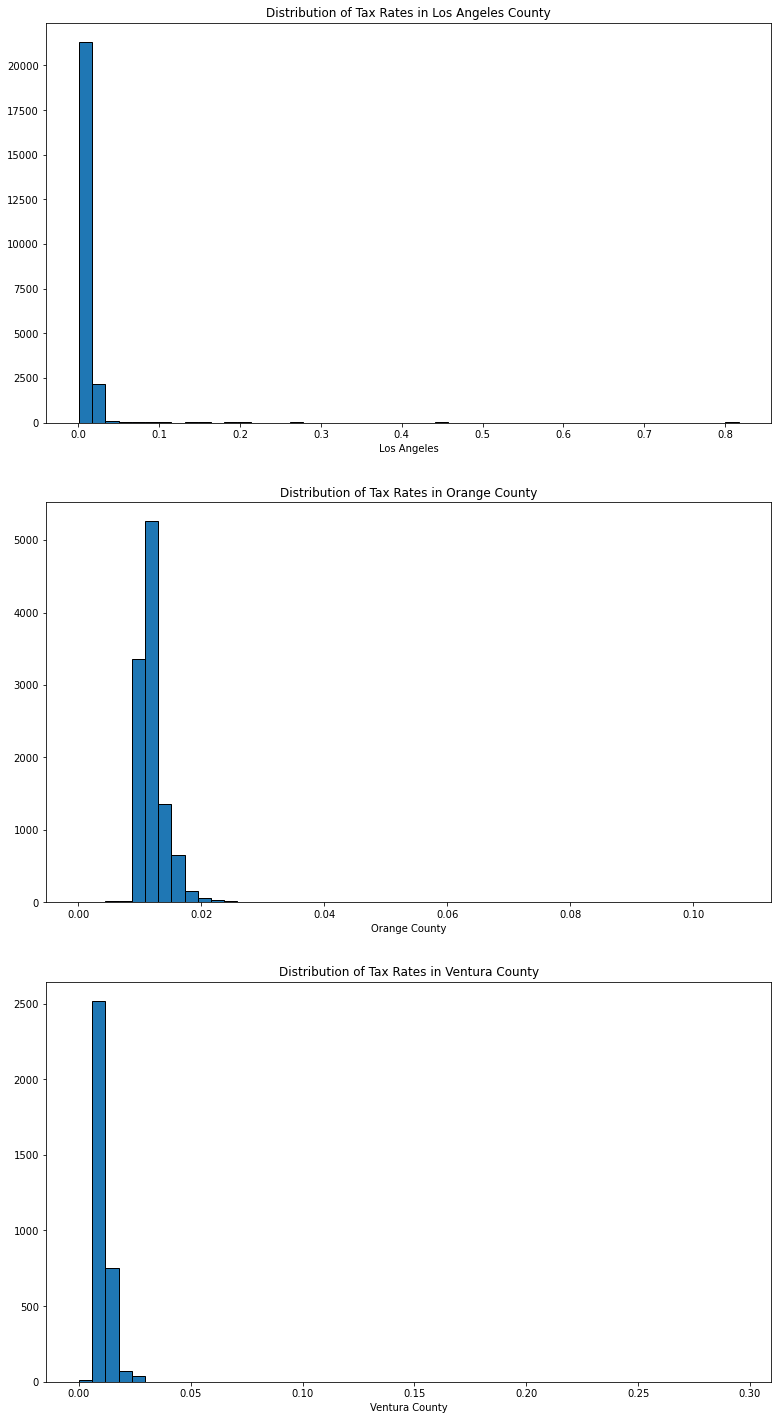

In [42]:
plt.figure(figsize=(13,25))
plt.subplot(3,1,1, xlabel = 'Los Angeles', title='Distribution of Tax Rates in Los Angeles County')
plt.hist(data=cal_tax[cal_tax.fips == 6037],bins=50, x='tax_rate',ec='black')

plt.subplot(3,1,2, xlabel = 'Orange County',title='Distribution of Tax Rates in Orange County')
plt.hist(data=cal_tax[cal_tax.fips == 6059],bins=50, x='tax_rate', ec='black')

plt.subplot(3,1,3, xlabel = 'Ventura County', title='Distribution of Tax Rates in Ventura County')
plt.hist(data=cal_tax[cal_tax.fips == 6111],bins=50, x='tax_rate',ec='black')

plt.show()

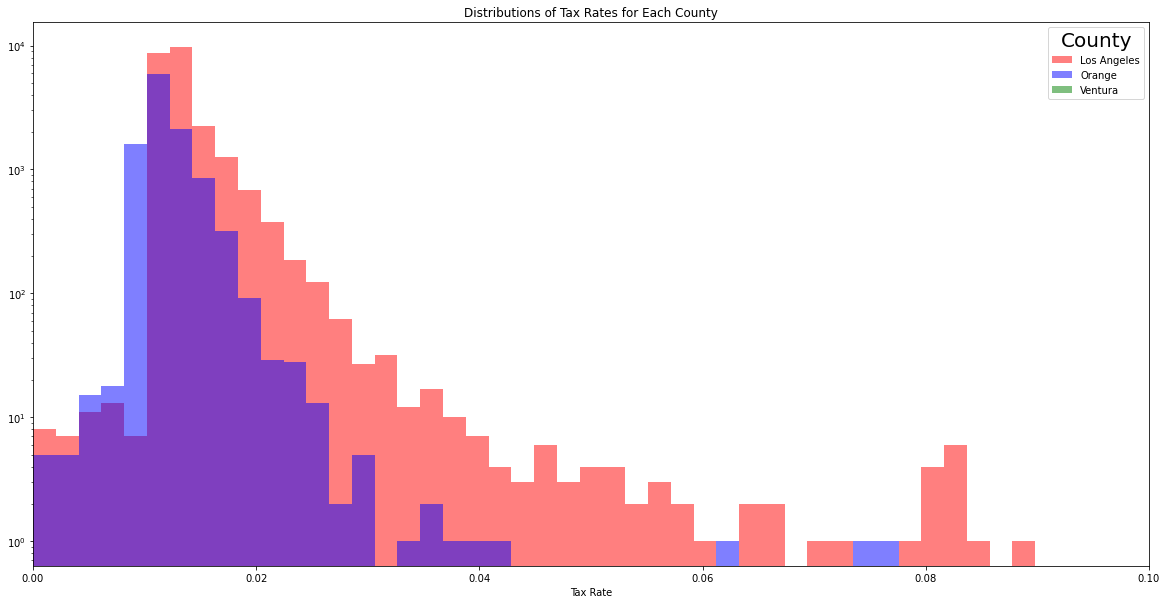

In [43]:
#all the tax distributions on one graph
plt.figure(figsize=(20,10))
    # start plot
plt.hist(cal_tax[cal_tax.county == 'Los Angeles'].tax_rate, bins=np.linspace(0, 0.1, 50), color='red', alpha=0.50, log=True, label='Los Angeles')
plt.hist(cal_tax[cal_tax.county == 'Orange'].tax_rate, bins=np.linspace(0, 0.1, 50), color='blue', alpha=0.50, log=True, label='Orange')
plt.hist(cal_tax[cal_tax.county == 'Venture'].tax_rate, bins=np.linspace(0, 0.1, 50), color='green', alpha=0.50, log=True, label='Ventura')
plt.rcParams['legend.title_fontsize'] = 20
plt.xlim(0, 0.1)
plt.xlabel('Tax Rate')
plt.title('Distributions of Tax Rates for Each County')
plt.legend(title='County')
plt.show()

Takeaways:

Most properties in our set were from Los Angeles, and they have higher tax rates than Orange or Ventura county.

Los Angeles County, even after dropping outliers, skewed to the right on tax rates.

Orange and Ventura county seem to have very close tax rates, but seems to be more diversity in Orange.

In [44]:
cal_tax

,sqft,baths,beds,tax_value,fips,tax_amount,age,tax_rate,county
parcel_id,,,,,,,,,
14634203,1125.0,2.0,3.0,289445.0,6059.0,3490.16,43.0,0.012058,Orange
11721753,1316.0,2.0,3.0,205123.0,6037.0,2627.48,94.0,0.012809,Los Angeles
11289917,1458.0,2.0,3.0,136104.0,6037.0,2319.90,47.0,0.017045,Los Angeles
11637029,1766.0,2.0,3.0,810694.0,6037.0,9407.01,37.0,0.011604,Los Angeles
11705026,1421.0,1.0,2.0,35606.0,6037.0,543.69,106.0,0.015270,Los Angeles
...,...,...,...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,6059.0,11662.88,15.0,0.013676,Orange
12019061,769.0,2.0,1.0,492395.0,6037.0,6023.37,53.0,0.012233,Los Angeles
11570288,1212.0,2.0,2.0,600608.0,6037.0,7255.87,48.0,0.012081,Los Angeles


In [45]:
cal_tax.to_csv('county_tax')

# Conclusions

To conclude... We took a very large Zillow dataset and condensed it down to 38,622 rows to work with. We dropped rows with outliers of 3 standard deviations above or below the mean for that column.

1.) Square footage was the best feature. As square footage increased, the value increased.

2.) The more bedrooms and bathrooms a house has, the more it was worth. These number of rooms also related to square footage in a positive relationship.

3.) Using all of square footage, number of bedrooms, number of bathrooms, into a model performed better than the baseline.

4.) All three counties have similar tax rates, but LA has the highest.



With more time, I would look into the other feature columns such as age and see if they could contribute positively to our prediction model with some cleaning up on nulls and outliers. 

FIPS was not a great indicator for value on how general it is.